# Part 1. Web Scraping Amazon Top Movie Chart and set up for Regression

In [1]:
!pip3 install beautifulsoup4

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import time
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests

In [125]:
no_pages = 2

def get_data(pageNo):  
    headers = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:66.0) Gecko/20100101 Firefox/66.0", "Accept-Encoding":"gzip, deflate", "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", "DNT":"1","Connection":"close", "Upgrade-Insecure-Requests":"1"}

    r = requests.get('https://www.amazon.com/gp/bestsellers/movies-tv/?ie=UTF8&ref_=sv_mov_2'+str(pageNo)+'?ie=UTF8&pg='+str(pageNo), headers=headers)#, proxies=proxies)
    content = r.content
    soup = BeautifulSoup(content)
    #print(soup)

    alls = []
    for d in soup.findAll('div', attrs={'class':'a-section a-spacing-none aok-relative'}):
        #print(d)
        name = d.find('span', attrs={'class':'zg-text-center-align'})
        n = name.find_all('img', alt=True)
        #print(n[0]['alt'])
        author = d.find('span', attrs={'class':'a-size-small a-color-base'})
        stream_format = d.find('span', attrs={'class':'a-size-small a-color-secondary'})
        rating = d.find('span', attrs={'class':'a-icon-alt'})
        users_rated = d.find('a', attrs={'class':'a-size-small a-link-normal'})
        price = d.find('span', attrs={'class':'p13n-sc-price'})

        all1=[]

        if name is None:
            all1.append("unknown-product")

        else:
            all1.append(n[0]['alt'])

        if author is not None:
            
            all1.append(author.text)
            
        elif author is None:
            
            author = d.find('span', attrs={'class':'a-size-small a-color-base'})
            
            if author is not None:
                all1.append(author.text)
            else:    
                all1.append('0')
                
        if stream_format is not None:
            
            all1.append(stream_format.text)      

        if rating is not None:
            all1.append(rating.text[0:3])

        if users_rated is not None:
            #print(price.text)
            all1.append(users_rated.text)
            
        else:
            all1.append('0')     

        if price is not None:
            all1.append(price.text[1:7])
        else:
            all1.append('0')
        alls.append(all1)    
    return alls

In [302]:
results = []
for i in range(1, no_pages+1):
    results.append(get_data(i))
flatten = lambda l: [item for sublist in l for item in sublist]
df = pd.DataFrame(flatten(results),columns=['Book Name','Author','Stream','Rating_out_of_5','Number_of_Ratings', 'Price'])
df

,Book Name,Author,Stream,Rating_out_of_5,Number_of_Ratings,Price
0,The Office: The Complete Series,Bill Boll,DVD,4.8,"19,946",47.99
1,Harry Potter: Complete 8-Film Collection [Blu-...,Daniel Radcliffe,Blu-ray,4.8,"67,479",48.79
2,The Lord of the Rings: The Motion Picture Tril...,Mark Ordesky,Blu-ray,4.8,"23,264",70.97
3,Harry Potter: The Complete 8-Film Collection,Daniel Radcliffe,DVD,4.8,"67,479",42.51
4,Parks and Recreation: The Complete Series,Amy Poehler,DVD,4.9,"4,440",29.99
...,...,...,...,...,...,...
95,Joker,Joaquin Phoenix,Blu-ray,4.5,"123,942",18.74
96,Illumination Presents: 3-Movie Collection (Des...,Steve Carell,Blu-ray,4.9,"3,591",24.11
97,Spider-Man: Far from Home / Spider-Man: Homeco...,Tom Holland,Blu-ray,4.9,"2,128",20.74
98,Samurai Champloo: The Complete Series [Blu-ray],Kirk Thornton,Blu-ray,4.9,"2,768",24.99


In [303]:
# Removing commas for rating counts over 1000.
df["Number_of_Ratings"].astype('str')
df["Number_of_Ratings"] = df["Number_of_Ratings"].str.replace(',', '')

In [304]:
df["Number_of_Ratings"]

0      19946
1      67479
2      23264
3      67479
4       4440
       ...  
95    123942
96      3591
97      2128
98      2768
99      1660
Name: Number_of_Ratings, Length: 100, dtype: object

In [305]:
#One- Hot Encoding Stream variable using Panda, in order to utilize binary encoded stream type data.

def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    return(res)

In [306]:
# Stream_Blu-ray = 1 means Blu Ray, Stream_Blu-ray = 0 means DVD.
df = encode_and_bind(df, 'Stream')
df = df.drop(columns= ['Stream','Stream_DVD'])
df = df.rename(columns={"Stream_Blu-ray": "Stream_Blu_ray"})
df[0:30]

,Book Name,Author,Rating_out_of_5,Number_of_Ratings,Price,Stream_Blu_ray
0,The Office: The Complete Series,Bill Boll,4.8,19946,47.99,0
1,Harry Potter: Complete 8-Film Collection [Blu-...,Daniel Radcliffe,4.8,67479,48.79,1
2,The Lord of the Rings: The Motion Picture Tril...,Mark Ordesky,4.8,23264,70.97,1
3,Harry Potter: The Complete 8-Film Collection,Daniel Radcliffe,4.8,67479,42.51,0
4,Parks and Recreation: The Complete Series,Amy Poehler,4.9,4440,29.99,0
5,Friends: The Complete Series Collection,Courteney Cox,4.8,17651,55.19,0
6,Cowboy Bebop: The Complete Series [Blu-ray],Wendee Lee,4.9,7461,24.95,1
7,Harry Potter: 8-Film Collection [4K Ultra HD +...,Daniel Radcliffe,4.8,67479,122.99,1
8,Friends: The Complete Series (Repackaged/Blu-ray),Various,4.8,17651,59.96,1
9,The Hobbit: Motion Picture Trilogy [Blu-ray],Peter Jackson,4.8,3385,69.94,1


In [307]:
df["Price"] = df.Price.astype(float)
df["Rating_out_of_5"] = df.Rating_out_of_5.astype(float)
df["Number_of_Ratings"] = df.Number_of_Ratings.astype(int)
df["Stream_Blu_ray"] = df.Stream_Blu_ray.astype(int)

In [308]:
df = df.sort_values('Stream_Blu_ray')
df[0:26]

,Book Name,Author,Rating_out_of_5,Number_of_Ratings,Price,Stream_Blu_ray
0,The Office: The Complete Series,Bill Boll,4.8,19946,47.99,0
82,Doctor Who: The Christopher Eccleston & David ...,Various,4.8,2661,19.99,0
77,The Three Stooges: The Complete DVD Collection,Shemp Howard,4.8,910,35.47,0
74,Centennial: The Complete Series,Richard Chamberlain,4.7,3822,26.99,0
72,Justified: The Complete Series,Timothy Olyphant,4.8,3094,37.99,0
70,Doctor Who: The Matt Smith Collection,Various,4.9,3110,28.55,0
37,Downton Abbey: The Complete Series,Hugh Bonneville,4.8,211,44.39,0
19,Game of Thrones: Complete Series,Nikolaj Coster-Waldau,4.7,5117,118.48,0
66,Everybody Loves Raymond: The Complete Series,Various,4.8,2227,96.81,0
42,Full House: The Complete Series Collection (Re...,Various,4.8,1933,68.67,0


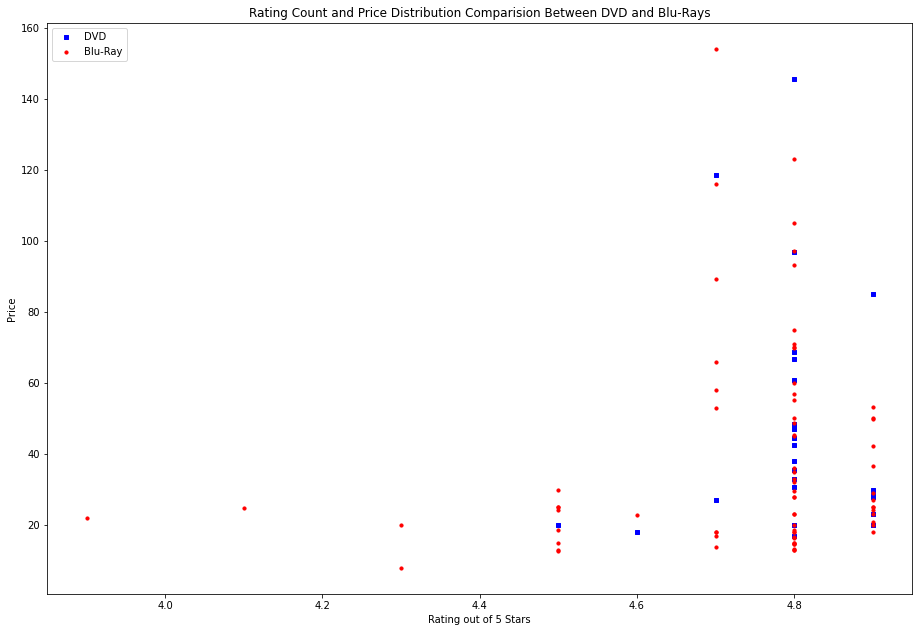

In [309]:
import matplotlib.pyplot as plt
x = df["Rating_out_of_5"]
y = df["Price"]
fig = plt.figure()
ax2 = fig.add_subplot(111)

ax2.scatter(x[0:26], y[0:26], s=10, c='b', marker="s", label='DVD')
ax2.scatter(x[26:100],y[26:100], s=10, c='r', marker="o", label='Blu-Ray')
plt.legend(loc='upper left');
plt.xlabel('Rating out of 5 Stars')
plt.ylabel('Price')
fig.set_size_inches(15.5, 10.5, forward=True)
plt.title('Rating Count and Price Distribution Comparision Between DVD and Blu-Rays')
plt.show()

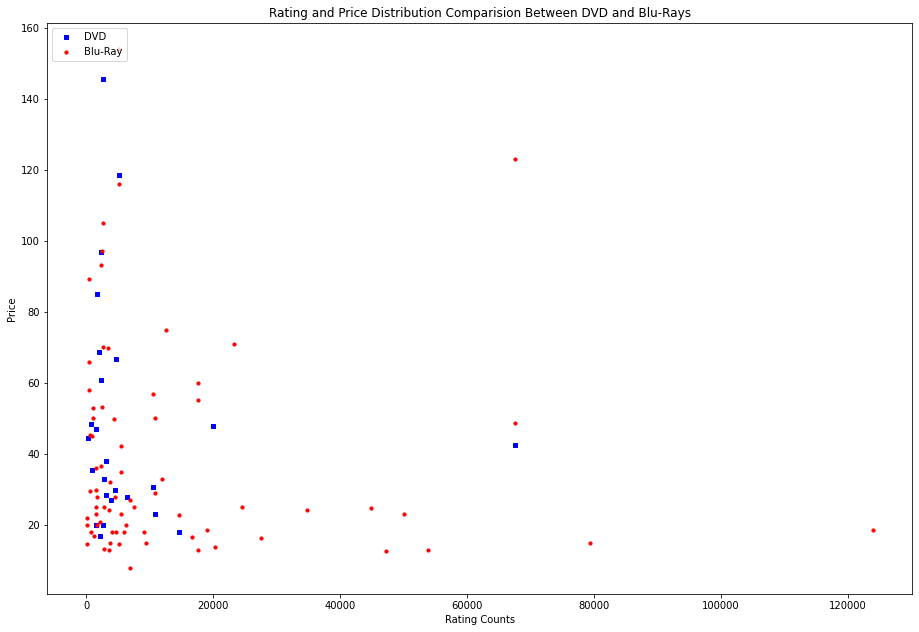

In [310]:
import matplotlib.pyplot as plt
x = df["Number_of_Ratings"]
y = df["Price"]
fig = plt.figure()
ax2 = fig.add_subplot(111)

ax2.scatter(x[0:26], y[0:26], s=10, c='b', marker="s", label='DVD')
ax2.scatter(x[26:100],y[26:100], s=10, c='r', marker="o", label='Blu-Ray')
plt.legend(loc='upper left');
plt.xlabel('Rating Counts')
plt.ylabel('Price')
fig.set_size_inches(15.5, 10.5, forward=True)
plt.title('Rating and Price Distribution Comparision Between DVD and Blu-Rays')
plt.show()

Scatterplots above show us 

i) DVD films tends to have higher ratings with 0 movies under 4.5 stars. -- Possible correlation between Price and Stream Type.

ii) Most of the movies have 4.7 or higher star rating.

iiI) Most of the movies have less than 20000 reviews, and movies with many review counts (>= 20000) are mostly Blu-Ray movies.

array([[<AxesSubplot:title={'center':'Rating_out_of_5'}>]], dtype=object)

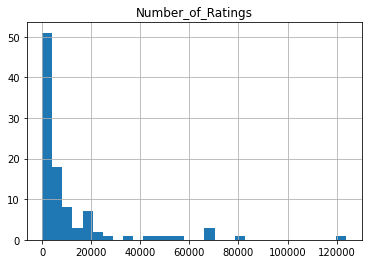

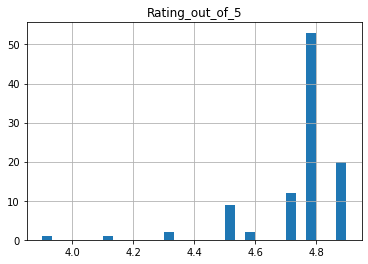

In [374]:
df.hist(column = 'Number_of_Ratings', bins = 30)
df.hist(column = 'Rating_out_of_5', bins = 30)

# 2. Predicting streaming method using Logistic Regression

In [375]:
df2 = df.drop(columns = ['Book Name','Author'])
df2

,Rating_out_of_5,Number_of_Ratings,Price,Stream_Blu_ray
0,4.8,19946,47.99,0
82,4.8,2661,19.99,0
77,4.8,910,35.47,0
74,4.7,3822,26.99,0
72,4.8,3094,37.99,0
...,...,...,...,...
33,4.5,79433,14.96,1
32,4.8,2759,13.12,1
31,4.8,2258,93.11,1
29,4.8,9114,17.99,1


In [376]:
from sklearn.model_selection import train_test_split

df2_train, df2_test = train_test_split(df2, test_size=0.3, random_state=88)
df2_train.shape, df2_test.shape

((70, 4), (30, 4))

In [377]:
# Default Baseline Model

default_false = np.sum(df2_train['Stream_Blu_ray'] == 0)
default_true = np.sum(df2_train['Stream_Blu_ray'] == 1)

print(pd.Series({'0': default_false, '1': default_true}))

0    20
1    50
dtype: int64


,Rating_out_of_5,Number_of_Ratings,Price,Stream_Blu_ray
Rating_out_of_5,1.000000,-0.179633,0.116258,-0.204481
Number_of_Ratings,-0.179633,1.000000,-0.023925,0.105225
Price,0.116258,-0.023925,1.000000,-0.106344
Stream_Blu_ray,-0.204481,0.105225,-0.106344,1.000000


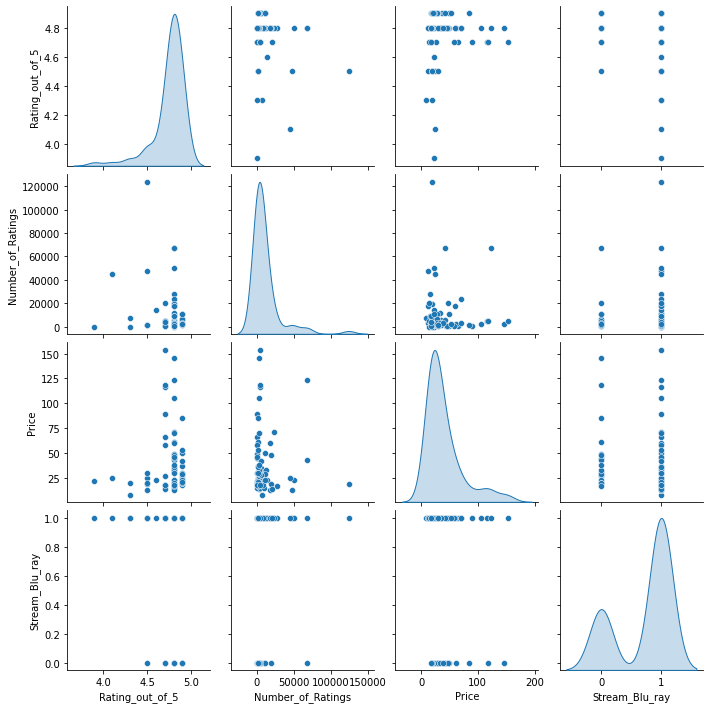

In [378]:
import seaborn as sns
sns.pairplot(df2_train,diag_kind='kde')
df2_train.corr()

In [379]:
# Accuracy of baseline model based on training data:
ACC = default_false/(default_false + default_true) 
ACC

0.2857142857142857

In [380]:
import statsmodels.formula.api as smf


In [381]:
# Fit the logistic regression model

logreg = smf.logit(formula = 'Stream_Blu_ray ~ Rating_out_of_5 + Number_of_Ratings + Price', data = df2_train).fit()

print(logreg.summary())

Optimization terminated successfully.
         Current function value: 0.562831
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         Stream_Blu_ray   No. Observations:                   70
Model:                          Logit   Df Residuals:                       66
Method:                           MLE   Df Model:                            3
Date:                Wed, 23 Jun 2021   Pseudo R-squ.:                 0.05924
Time:                        18:53:59   Log-Likelihood:                -39.398
converged:                       True   LL-Null:                       -41.879
Covariance Type:            nonrobust   LLR p-value:                    0.1746
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            20.0409     12.913      1.552      0.121      -5.268      45.350
Rating_o

In [382]:
y_test = df2_test['Stream_Blu_ray']

y_prob = logreg.predict(df2_test)
y_pred = pd.Series([1 if x > 0.60 else 0 for x in y_prob], index=y_prob.index)

In [383]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print ("Confusion Matrix : \n", cm) 
accuracy1 = (cm.ravel()[0]+cm.ravel()[3])/sum(cm.ravel())
# Accuracy
print('Accuracy for the Logistic Model  %s ' % accuracy1)

Confusion Matrix : 
 [[ 1  6]
 [ 3 20]]
Accuracy for the Logistic Model  0.7 


In [384]:
# compare the confusion matrix of the baseline model
cm_baseline = confusion_matrix(df2_test['Stream_Blu_ray'],[0]*df2_test.shape[0])
accuracy2 = (cm_baseline.ravel()[0]+cm_baseline.ravel()[3])/sum(cm_baseline.ravel())
print('Accuracy for the Baseline Model  %s ' % accuracy2)

Accuracy for the Baseline Model  0.23333333333333334 


The Model I built performs with 63% accuracy, which is about 47% of accuracy improvement from the Baseline model. Even though we cannot logically justify how reviews and price are correlated to streaming type, it was a good practice to work on creating data by scraping/cleaning raw data and utilizing it to make a regression model.